[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/devdastl/EVA-8_Phase-1_Assignment-1)

In [ ]:
import os
!git clone https://github.com/devdastl/eva8_source.git
os.chdir('eva8_source')

fatal: destination path 'eva8_source' already exists and is not an empty directory.


In [ ]:
import torch
import torch.nn
import copy
import torch.optim as optim
from dataset.data import DataLoader
my_loader= DataLoader(dataset_name='CIFAR10', batch_size=512)

train_loader, test_loader = my_loader.get_loader()

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch.nn as nn

class residual(nn.Module):
    def __init__(self, res_block):
        super().__init__()
        self.res_block = res_block

    def forward(self, x):
        return self.res_block(x) + x

class MixerModel():
    def __init__(self, dim, depth, kernel_size=5, patch_size=2, n_classes=10):
        self.depth = depth
        self.dim = dim
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.n_classes = n_classes

    def depth_wise(self):
        return nn.Sequential(
            nn.Conv2d(self.dim, self.dim, kernel_size=self.kernel_size, groups=self.dim, padding="same"),
            nn.GELU(),
            nn.BatchNorm2d(self.dim)
        )
    def point_wise(self):
        return nn.Sequential(
            nn.Conv2d(self.dim, self.dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(self.dim)
        )

    def get_model(self):
        embedding_prep = nn.Sequential(
            nn.Conv2d(3, self.dim, kernel_size=self.patch_size, stride=self.patch_size),
            nn.GELU(),
            nn.BatchNorm2d(self.dim)
        )

        depth_wise = nn.Sequential(
            nn.Conv2d(self.dim, self.dim, kernel_size=self.kernel_size, groups=self.dim, padding="same"),
            nn.GELU(),
            nn.BatchNorm2d(self.dim)
        )   

        point_wise =  nn.Sequential(
            nn.Conv2d(self.dim, self.dim, kernel_size=1),
            nn.GELU(),
            nn.BatchNorm2d(self.dim)
        )

        mixer_block = [nn.Sequential(
            residual(self.depth_wise()),
            self.point_wise()
        ) for i in range(self.depth)]

        model = nn.Sequential(
            embedding_prep,
            *mixer_block,
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(self.dim, self.n_classes)
        )

        return model


In [ ]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
depth = 10
hdim = 256
psize = 2
conv_ks = 5
clip_norm = True

model = MixerModel(hdim, depth, patch_size=psize, kernel_size=conv_ks, n_classes=10).get_model()


summary(model.to(device), input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 16, 16]           3,328
              GELU-2          [-1, 256, 16, 16]               0
       BatchNorm2d-3          [-1, 256, 16, 16]             512
            Conv2d-4          [-1, 256, 16, 16]           6,656
              GELU-5          [-1, 256, 16, 16]               0
       BatchNorm2d-6          [-1, 256, 16, 16]             512
          residual-7          [-1, 256, 16, 16]               0
            Conv2d-8          [-1, 256, 16, 16]          65,792
              GELU-9          [-1, 256, 16, 16]               0
      BatchNorm2d-10          [-1, 256, 16, 16]             512
           Conv2d-11          [-1, 256, 16, 16]           6,656
             GELU-12          [-1, 256, 16, 16]               0
      BatchNorm2d-13          [-1, 256, 16, 16]             512
         residual-14          [-1,

In [ ]:
!python -m pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from main import ModelExecuter
import copy
import torch.optim as optim

start_lr = 1e-6
end_lr = 0.1

net = MixerModel(hdim, depth, patch_size=psize, kernel_size=conv_ks, n_classes=10).get_model().to(device)

criterion = torch.nn.CrossEntropyLoss()

executer_instance = ModelExecuter(criterion=criterion, device='cuda', 
                                  train_loader=train_loader, test_loader=test_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
Min Loss = 1.911323412715004, Max LR = 0.1
LR suggestion: steepest gradient
Suggested LR: 3.94E-02


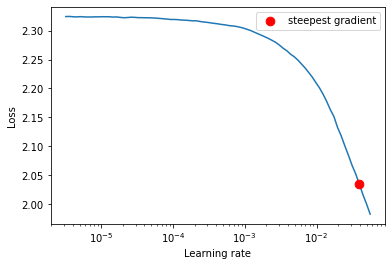

In [ ]:
net_exp = copy.deepcopy(net)
optimizer_exp = optim.SGD(net_exp.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)

min_loss, max_lr= executer_instance.find_lr(net_exp, optimizer_exp, end_lr=end_lr, num_iter=100, step_mode='exp')

In [ ]:
EPOCH = 24
optimizer=torch.optim.SGD(net.parameters(), lr=start_lr, momentum=0.90, weight_decay=0.005)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=max_lr, steps_per_epoch=len(train_loader),
                                                epochs=EPOCH, pct_start=5/EPOCH, div_factor=10, three_phase=False, final_div_factor=10, anneal_strategy='linear')

lr_hist = executer_instance.execute_training(net, optimizer=optimizer, scheduler=scheduler, NUM_EPOCH=24)

EPOCH: 1


Loss=1.4373283386230469 Batch_id=97 Accuracy=36.79: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0030, Accuracy: 4585/10000 (45.85%)

EPOCH: 2


Loss=1.182661771774292 Batch_id=97 Accuracy=53.49: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0028, Accuracy: 4898/10000 (48.98%)

EPOCH: 3


Loss=1.042649269104004 Batch_id=97 Accuracy=59.56: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0025, Accuracy: 5599/10000 (55.99%)

EPOCH: 4


Loss=1.147926926612854 Batch_id=97 Accuracy=62.62: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0024, Accuracy: 5785/10000 (57.85%)

EPOCH: 5


Loss=0.9772413372993469 Batch_id=97 Accuracy=64.11: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0022, Accuracy: 6386/10000 (63.86%)

EPOCH: 6


Loss=0.9716292023658752 Batch_id=97 Accuracy=65.54: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0027, Accuracy: 5175/10000 (51.75%)

EPOCH: 7


Loss=0.8858718872070312 Batch_id=97 Accuracy=65.90: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0024, Accuracy: 5616/10000 (56.16%)

EPOCH: 8


Loss=0.9253241419792175 Batch_id=97 Accuracy=67.12: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0018, Accuracy: 6925/10000 (69.25%)

EPOCH: 9


Loss=1.0201915502548218 Batch_id=97 Accuracy=67.70: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0019, Accuracy: 6650/10000 (66.50%)

EPOCH: 10


Loss=0.9948711395263672 Batch_id=97 Accuracy=67.97: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0022, Accuracy: 6248/10000 (62.48%)

EPOCH: 11


Loss=0.9139022827148438 Batch_id=97 Accuracy=68.53: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0021, Accuracy: 6468/10000 (64.68%)

EPOCH: 12


Loss=0.8752293586730957 Batch_id=97 Accuracy=69.08: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0017, Accuracy: 7131/10000 (71.31%)

EPOCH: 13


Loss=0.744451642036438 Batch_id=97 Accuracy=69.10: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0018, Accuracy: 6842/10000 (68.42%)

EPOCH: 14


Loss=0.8103665709495544 Batch_id=97 Accuracy=70.62: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0024, Accuracy: 5935/10000 (59.35%)

EPOCH: 15


Loss=0.8121353983879089 Batch_id=97 Accuracy=70.79: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0019, Accuracy: 6947/10000 (69.47%)

EPOCH: 16


Loss=0.7335755228996277 Batch_id=97 Accuracy=71.42: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0017, Accuracy: 7083/10000 (70.83%)

EPOCH: 17


Loss=0.8949453234672546 Batch_id=97 Accuracy=71.80: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0020, Accuracy: 6436/10000 (64.36%)

EPOCH: 18


Loss=0.7117620706558228 Batch_id=97 Accuracy=72.62: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0019, Accuracy: 6744/10000 (67.44%)

EPOCH: 19


Loss=0.7823443412780762 Batch_id=97 Accuracy=72.94: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0015, Accuracy: 7489/10000 (74.89%)

EPOCH: 20


Loss=0.7997847199440002 Batch_id=97 Accuracy=73.89: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0014, Accuracy: 7562/10000 (75.62%)

EPOCH: 21


Loss=0.8348914384841919 Batch_id=97 Accuracy=75.11: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0015, Accuracy: 7349/10000 (73.49%)

EPOCH: 22


Loss=0.6712363958358765 Batch_id=97 Accuracy=75.77: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0012, Accuracy: 8077/10000 (80.77%)

EPOCH: 23


Loss=0.5587685704231262 Batch_id=97 Accuracy=77.41: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0011, Accuracy: 8120/10000 (81.20%)

EPOCH: 24


Loss=0.5845258235931396 Batch_id=97 Accuracy=79.38: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]


generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24
generating mis-classified images for epoch 24

Test set: Average loss: 0.0009, Accuracy: 8512/10000 (85.12%)

